# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

# Table of contents

A. Import needed packages

B. Define custom functions that are used in the Notebook 

0. Inspect the dataset
0.1 Load the data



In [379]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import missingno as msno


# ml
from imblearn.over_sampling import SMOTE

from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb
import pickle
# magic word for producing visualizations in notebook
%matplotlib inline

In [ ]:
# Custom Functions for data preprocessing

def inspect_missings_column(df, bins = 10):
    
    '''
   This function investigates the missings columnwise the dataset based on columns and plots some inforamtion
   
   Input:  df (df)- a dataframe that holds the data to be analyzid
          int (bins) - a nuber that indicats in how many bins the data should be subdivided for the analysis 
   
    '''

    for i in np.arange(0,100,bins):
        num_missings = (df.isnull().sum(axis=0)/df.shape[0] >= i/100).sum()
        percentage = round((num_missings / df.shape[1])*100,0)
        
        print('There are {} columns that have {}% or more missings. That are {}% of all columns.'.format(num_missings,i,percentage))
        
    #plotting the top 50 columsn with the most missing values 
    df_missing_info = df.isna().mean().sort_values(ascending = False)
    ax = azdias_missings_info.sort_values(ascending=False).head(50).plot(kind='bar', figsize=(20,5), title='Missing Vlaues proportion for top 50 attirbutes')
    ax.set_xlabel("Column name")
    ax.set_ylabel("Share of missing values %")
    
    #plotting a distribution of missing coliumns
    fig, ax = plt.subplots(figsize= (20,5))
    fig.suptitle('Disribution of missing values of the dataset')
    sns.distplot(df_missing_info, bins = 100, color = 'r' )  



def inspect_missings_row(df, bins = 10):
    
    '''
    Investigates and plots inforamtion about the missings in the rows. 
    INPUT:
    df (df) - Data set that is tested on missings per row and plots some inforamtion. 
    int (bins)- Number of bins that for the data can be grouped into. 
    '''
    
    
    print('Looking at the given dataset with a number of bins of  {} '.format(bins))
    
    missings_list = []
    
    for i in range(10, 110, bins):
        missings = df[df.isnull().mean(axis=1).values > i/100].shape[0]
        missings_list.append(missings)
        
        print('{} of all rows have {} missings or less, that are {}%. '.format(missings, i, round(missings/df.shape[0]*100)))
        
    # Plot distribution of missing values
    fig, ax = plt.subplots(figsize= (20,5))
    fig.suptitle('Disribution of missing values of the dataset')
    sns.distplot(azdias.isna().sum(axis=1), color = 'r' ) 
    
    
    

def change_unknown_to_nan(df):
    '''
    This function replaces all the values that are labled as unknown in the refernence excel file as null.
    INPUT: 
       df (df)- dataframe as input.
    OUTPUT:
        df(nan_df)- dataframe with unknown data labeld as NaNs.
    '''
    
    print('===============Changing the Unkown Data to NaNs======================')
    #load in the values from the dias excel 
    dias_values = pd.read_excel("DIAS Attributes - Values 2017.xlsx", header=1)
    dias_values = dias_values.fillna(method='ffill')
    dias_values = dias_values.replace({"CAMEO_DEUINTL_2015":"CAMEO_INTL_2015", "SOHO_FLAG":"SOHO_KZ", "D19_BUCH":"D19_BUCH_CD"})
    dias_values['Attribute'] = dias_values['Attribute'].map(lambda x: x.replace("_RZ", ""))

    # serch for the phrases in the "Meaning" Column for which values that shall be replaced as nan 
    nan_values = dias_values[(dias_values['Meaning'].str.contains('unknown')) | \
                             (dias_values['Meaning'].str.contains('no transaction known')) | \
                             (dias_values['Meaning'].str.contains('no main age detectable')) | \
                             (dias_values['Meaning'].str.contains('no transactions known'))]
    
    
    nan_ref = nan_values[['Attribute','Value']]

    nan_doku_dict = nan_ref.set_index('Attribute')['Value'].to_dict()



    for k,v in nan_doku_dict.items():
        if isinstance(v, str):
            v_new = {int(v): np.nan for v in v.split(",")}
            nan_doku_dict[k] = v_new
        else:
            v_new = {v : np.nan}
            nan_doku_dict[k] = v_new



    nan_df = df.replace(nan_doku_dict)
    
    #Edit some columns manually 
    nan_df['CAMEO_DEU_2015'].replace({'X': np.nan, 'XX':np.nan},inplace = True)
    nan_df['CAMEO_INTL_2015'].replace({'X': np.nan, 'XX':np.nan},inplace = True)
    nan_df['CAMEO_DEUG_2015'].replace({'X': np.nan, 'XX':np.nan},inplace = True)

    print('=====================================================================')

    return nan_df



def rem_nas(df, thresh_col = 0.9, thresh_row = 0.9):
    '''
    
    This function removes columns and rows that exeed a cirtain threshold of NaNs. 
    
    Input: df- The datframe for wich columns and rows should be removed 
    
    Output: df (df_clean)- A dataframe with reduced columns and rows based on the missing thresholds. 
    '''
    
    print('============Remiving Columns and Rows with to many NaNs==============')
    
    df_col =df.copy()
    
    print('---------Remove columns with more than {}% missings------------'.format(round(thresh_col*100)))
    print('The shape of the old dataframe:',df_col.shape)
    df_col = df_col.dropna(axis = 1 , thresh = df_col.shape[0]*(1 - thresh_col))
    print('The shape of the new dataframe:' ,df_col.shape)
    print('{} columns have been removed from the dataframe.'.format(df.shape[1]-df_col.shape[1]))

    print('----------------------------------------------------------------')
    
    print('---------Remove rows with more than {}% missings------------'.format(round(thresh_row*100)))
    print('The shape of the old dataframe:',df_col.shape)
    
    df_clean = df_col.dropna(axis = 0 , thresh = df_col.shape[1]*(1-thresh_row))
    print('The shape of the new dataframe:' ,df_clean.shape)
    print('{} rows have been removed from the dataframe.'.format(df_col.shape[0]-df_clean.shape[0]))
   
    return df_clean

    print('=====================================================================')



def impute_missings(df):
    
    
    '''
    This function imputes the missing values using differnt strategies that have been derived from the data inspection. 
    
    Input: 
        df (df)- Dataframe that for wich missing imputation should be applied.
        
    Output:
        df (df_imp)- Dataframe wich missings are imputed. 
    
    
    '''
    
        print('====================Data Imputation================================')

    
    # Check for each feature from the description file wich imputing strategy seams reasonable 
    df_imp = df.copy()
    
    
    
    unknown_10 = ['D19_BANKEN_DATUM','D19_BANKEN_OFFLINE_DATUM','D19_BANKEN_ONLINE_DATUM','D19_GESAMT_DATUM','D19_GESAMT_OFFLINE_DATUM','D19_GESAMT_ONLINE_DATUM' \
                  ,'D19_TELKO_DATUM','D19_TELKO_OFFLINE_DATUM','D19_TELKO_ONLINE_DATUM','D19_VERSAND_DATUM','D19_VERSAND_OFFLINE_DATUM','D19_VERSAND_ONLINE_DATUM']
    
    for col in unknown_10:
        try:
            df_imp[col].fillna(10,inplace = True)
        except: print('Col',col,'no in the df anymore.')
    
    print('Imputing 10er Values is done.')

    
    
    unknown_9 = ['KBA05_CCM1','ANREDE_KZ','KBA05_FRAU','KBA05_ALTER1','KBA05_ALTER2','KBA05_ALTER3','KBA05_ALTER4','KBA05_ANHANG']
    
    for col in unknown_9:
        try:
            df_imp[col].fillna(9,inplace = True)
        except: print('Col',col,'no in the df anymore.')
    print('Imputing 9er Values is done.')

    
    
    median = ['ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','ANZ_PERSONEN','GEBURTSJAHR']
    
    for col in median:
        try:
            df_imp[col].fillna(df_imp[col].median(),inplace = True)
        except: print('Col',col,'no in the df anymore.')

    print('Imputing Mean Values is done. ')

    
    most_frequent = ['BALLRAUM','CAMEO_DEUG_2015','CAMEO_DEU_2015','CJT_GESAMTTYP','D19_KONSUMTYP', 'EINGEFUEGT_AM','D19_LETZTER_KAUF_BRANCHE']
    
    for col in most_frequent:
        try:
            df_imp[col].fillna(list(df_imp[col].value_counts().index)[0],inplace = True)
        except: print('Col',col,'no in the df anymore.')

    print('Imputing most frequent values is done.')
                
    #Impute the rest with the simple imputer uning a constant vlaue 

    for col in df_imp.columns:
        df_imp[col].fillna(0,inplace=True)
    print('The rest of the columns are imputed with a zero. ')
    
    print('=====================================================================')
    
    return df_imp


def encode_data (df, categories = None):
    
    '''
    This fnction encodes the dataset. Default is that all "object" columns should be processed. 
    Optionaly it can take an array of manually selectd categorical colimns. 
    
    Input:
        df (df)- Dataframe that is to be endoded. 
    Output:
        df(enc_df)- Encoded dataframe. 
    
    '''
    
    
    enc_df = df.copy()
    enc_df.drop(['EINGEFUEGT_AM'], axis = 1,inplace = True)
    
    if categories == None: categories = df.select_dtypes(include='object').columns
        
    print(categories)
    
    for v in categories:
        try:
            enc_df = pd.concat([enc_df.drop(v, axis=1), pd.get_dummies(enc_df[v], prefix=v, prefix_sep='_', drop_first=True)], axis=1 )
            print('Encode:', v)
        except: print('Column ', v, ' not found.')
   
    return enc_df
    

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### 0.1 Load in the Dataa

In [3]:
%%time
# load in the data
dtypes = {'CAMEO_INTL_2015': object , 'CAMEO_DEUG_2015': object} # make sure the data is read in without mixed valeus errpr  
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', dtype=dtypes)
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';',dtype=dtypes)

CPU times: user 19.5 s, sys: 2.67 s, total: 22.2 s
Wall time: 22.2 s


### Import data descriptions

In [4]:
#load in the description file and process it so that it can be used for the analysis
desc_azdias = pd.read_excel('DIAS Attributes - Values 2017.xlsx', skiprows=1).drop('Unnamed: 0', axis=1)
desc_azdias.fillna(method='ffill', inplace=True) 
desc_azdias['Type'] = desc_azdias['Meaning'].apply(lambda x: 'ordinal' if 'coded' in x.lower() else ('continuous' if 'numeric' in x.lower() else 'categorical'))

# Fix the data so it can be used in a dataframe
desc_azdias = desc_azdias.merge(desc_azdias[desc_azdias['Meaning'].str.lower() == 'unknown'][['Attribute', 'Value']].rename({'Value':'Missing_Value'}, axis=1), on='Attribute', how='left').groupby(['Attribute']).agg(Description=('Description','first'), Type=('Type','first'), Unknown_Indicator=('Missing_Value','first')).reset_index()

### 2) Data Overview and Exploration

### 0.1 AZDIAS Dataset

In [5]:
print("The AZDIASD Dataset has {} rows.".format(azdias.shape[0]))
print("The AZDIASD Dataset has {} columns.".format(azdias.shape[1]))

The AZDIASD Dataset has 891221 rows.
The AZDIASD Dataset has 366 columns.


In [6]:
#looging at the azdias df
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [7]:
azdias.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LNR,891221.0,637263.000000,257273.486465,191653.0,414458.0,637263.0,860068.0,1082873.0
AGER_TYP,891221.0,-0.358435,1.198724,-1.0,-1.0,-1.0,-1.0,3.0
AKT_DAT_KL,817722.0,4.421928,3.638805,1.0,1.0,3.0,9.0,9.0
ALTER_HH,817722.0,10.864126,7.639683,0.0,0.0,13.0,17.0,21.0
ALTER_KIND1,81058.0,11.745392,4.097660,2.0,8.0,12.0,15.0,18.0
...,...,...,...,...,...,...,...,...
WOHNDAUER_2008,817722.0,7.908791,1.923137,1.0,8.0,9.0,9.0,9.0
WOHNLAGE,798073.0,4.052836,1.949539,0.0,3.0,3.0,5.0,8.0
ZABEOTYP,891221.0,3.362438,1.352704,1.0,3.0,3.0,4.0,6.0
ANREDE_KZ,891221.0,1.522098,0.499512,1.0,1.0,2.0,2.0,2.0


In [8]:
#Looking for missing values in the dataset

In [9]:
#check for missing values
azdias_missings_info = azdias.isna().mean().sort_values(ascending = False)

In [10]:
azdias_missings_info

ALTER_KIND4               0.998648
ALTER_KIND3               0.993077
ALTER_KIND2               0.966900
ALTER_KIND1               0.909048
EXTSEL992                 0.733996
                            ...   
D19_VERSI_ONLINE_DATUM    0.000000
D19_VERSICHERUNGEN        0.000000
D19_VOLLSORTIMENT         0.000000
D19_WEIN_FEINKOST         0.000000
LNR                       0.000000
Length: 366, dtype: float64

Text(0, 0.5, 'Share of missing values %')

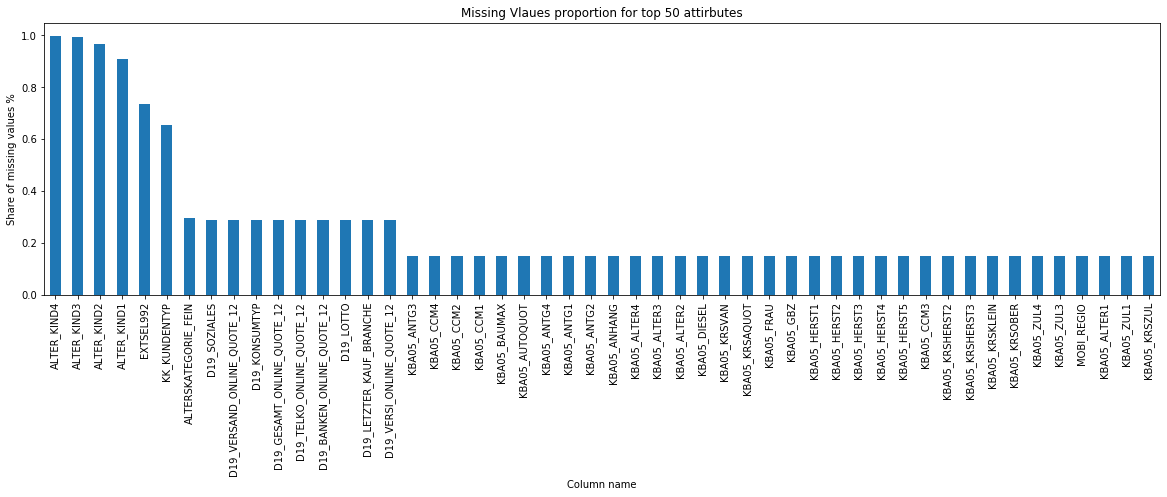

In [11]:
ax = azdias_missings_info.sort_values(ascending=False).head(50).plot(kind='bar', figsize=(20,5), title='Missing Vlaues proportion for top 50 attirbutes')
ax.set_xlabel("Column name")
ax.set_ylabel("Share of missing values %")


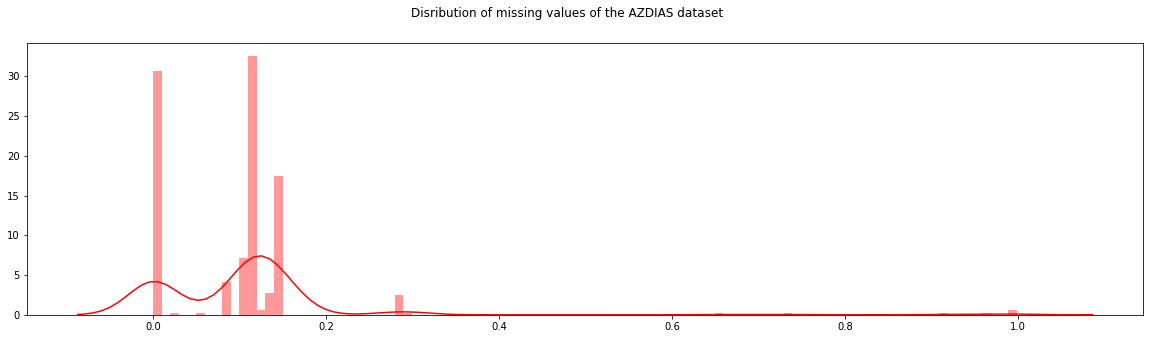

In [12]:
fig, ax = plt.subplots(figsize= (20,5))
fig.suptitle('Disribution of missing values of the AZDIAS dataset')
sns.distplot(azdias_missings_info, bins = 100, color = 'r' )       

In [13]:
# what are the occurring datatyps in the azdias dataset
azdias.dtypes.value_counts()

float64    267
int64       93
object       6
dtype: int64

In [14]:
azdias.select_dtypes(['int64']).columns

Index(['LNR', 'AGER_TYP', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24',
       'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS',
       'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH',
       'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD',
       'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT',
       'D19_GARTEN', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24',
       'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM',
       'D19_GESAMT_ONLINE_DATUM', 'D19_HANDWERK', 'D19_HAUS_DEKO',
       'D19_KINDERARTIKEL', 'D19_KONSUMTYP_MAX', 'D19_KOSMETIK',
       'D19_LEBENSMITTEL', 'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER',
       'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE',
       'D19_TECHNIK', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24',
       'D19_TELKO_DATUM', 'D19_TELKO_MOBILE', 'D19_TELKO_OFFLINE_DATUM',
       'D19_TELKO_ONLINE_DATUM', 'D19_TELKO_REST', 'D

### 0.2 Cusomer Dataset


In [15]:
print("The Customers Dataset has {} rows.".format(customers.shape[0]))
print("The Customers Dataset has {} columns.".format(customers.shape[1]))

The Customers Dataset has 191652 rows.
The Customers Dataset has 369 columns.


In [16]:
#looging at the customers df
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [17]:
#get sumarizing descriptive statistics of the customers df
customers.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LNR,191652.0,95826.500000,55325.311233,1.0,47913.75,95826.5,143739.25,191652.0
AGER_TYP,191652.0,0.344359,1.391672,-1.0,-1.00,0.0,2.00,3.0
AKT_DAT_KL,145056.0,1.747525,1.966334,1.0,1.00,1.0,1.00,9.0
ALTER_HH,145056.0,11.352009,6.275026,0.0,8.00,11.0,16.00,21.0
ALTER_KIND1,11766.0,12.337243,4.006050,2.0,9.00,13.0,16.00,18.0
...,...,...,...,...,...,...,...,...
WOHNLAGE,141725.0,3.723133,2.095540,0.0,2.00,3.0,5.00,8.0
ZABEOTYP,191652.0,2.576806,1.168486,1.0,1.00,3.0,3.00,6.0
ONLINE_PURCHASE,191652.0,0.090247,0.286536,0.0,0.00,0.0,0.00,1.0
ANREDE_KZ,191652.0,1.376432,0.484492,1.0,1.00,1.0,2.00,2.0


In [18]:
# what data types ocour how often in the df
customers.dtypes.value_counts()

float64    267
int64       94
object       8
dtype: int64

In [19]:
customers_missings_info = customers.isna().mean().sort_values(ascending = False)
customers_missings_info

ALTER_KIND4          0.998769
ALTER_KIND3          0.993347
ALTER_KIND2          0.973389
ALTER_KIND1          0.938607
KK_KUNDENTYP         0.584064
                       ...   
D19_VOLLSORTIMENT    0.000000
D19_WEIN_FEINKOST    0.000000
FINANZ_ANLEGER       0.000000
FINANZ_HAUSBAUER     0.000000
LNR                  0.000000
Length: 369, dtype: float64

Text(0.5, 1.0, 'Distribution of missing data')

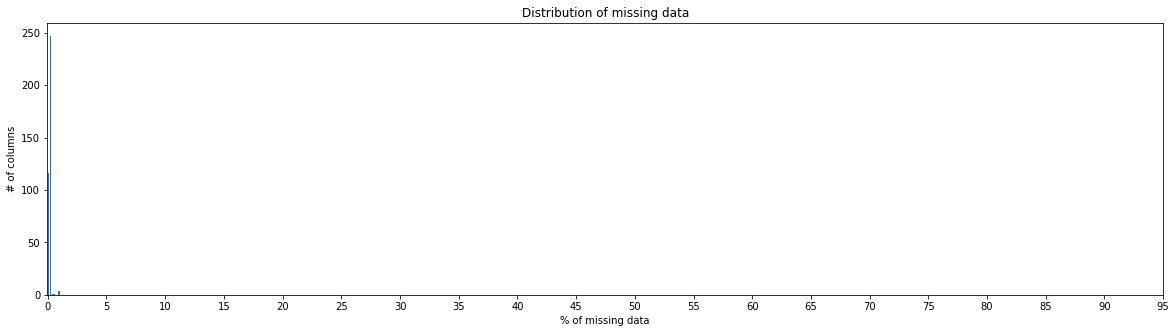

In [20]:
# Show the distribution of missings in the dataset
plt.figure(figsize=(20,5))
plt.hist(customers_missings_info)

plt.xticks(np.arange(0, 100, 5))
plt.ylabel('# of columns')
plt.xlabel('% of missing data')
plt.title('Distribution of missing data')

Text(0, 0.5, 'Share of missing values %')

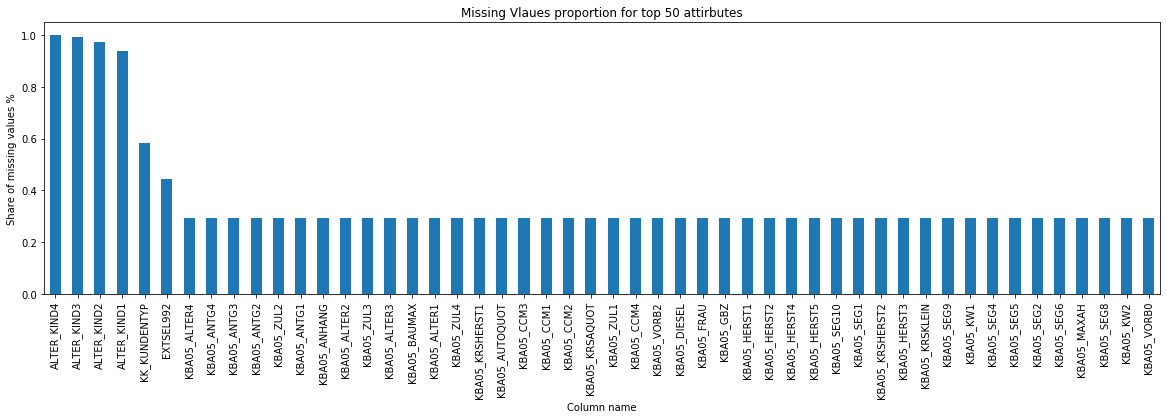

In [21]:
# Plot 50 columns with highest share of missing values
ax = customers_missings_info.sort_values(ascending=False).head(50).plot(kind='bar', figsize=(20,5), title='Missing Vlaues proportion for top 50 attirbutes')
ax.set_xlabel("Column name")
ax.set_ylabel("Share of missing values %")


### Comparing both Datasets

In [22]:
# Comparing the columns in azdias and customer
print('Number of columns in azdias:   ', azdias.shape[1])
print('Number of columns in customers:', customers.shape[1])
cols_cust_only = list(set(customers.columns).difference(set(azdias.columns)))
print('Columns in customer that do  not exists in azdias: ', cols_cust_only)

Number of columns in azdias:    366
Number of columns in customers: 369
Columns in customer that do  not exists in azdias:  ['ONLINE_PURCHASE', 'PRODUCT_GROUP', 'CUSTOMER_GROUP']


In [23]:
# Distribution of customers specific coluns 
customers['CUSTOMER_GROUP'].value_counts()   

MULTI_BUYER     132238
SINGLE_BUYER     59414
Name: CUSTOMER_GROUP, dtype: int64

In [24]:
customers['ONLINE_PURCHASE'].value_counts()

0    174356
1     17296
Name: ONLINE_PURCHASE, dtype: int64

In [25]:
customers['PRODUCT_GROUP'].value_counts()

COSMETIC_AND_FOOD    100860
FOOD                  47382
COSMETIC              43410
Name: PRODUCT_GROUP, dtype: int64

## Feature Engieering

### Missing Values

There are 366 columns that have 0% or more missings. That are 100.0% of all columns.
There are 237 columns that have 10% or more missings. That are 65.0% of all columns.
There are 16 columns that have 20% or more missings. That are 4.0% of all columns.
There are 6 columns that have 30% or more missings. That are 2.0% of all columns.
There are 6 columns that have 40% or more missings. That are 2.0% of all columns.
There are 6 columns that have 50% or more missings. That are 2.0% of all columns.
There are 6 columns that have 60% or more missings. That are 2.0% of all columns.
There are 5 columns that have 70% or more missings. That are 1.0% of all columns.
There are 4 columns that have 80% or more missings. That are 1.0% of all columns.
There are 4 columns that have 90% or more missings. That are 1.0% of all columns.


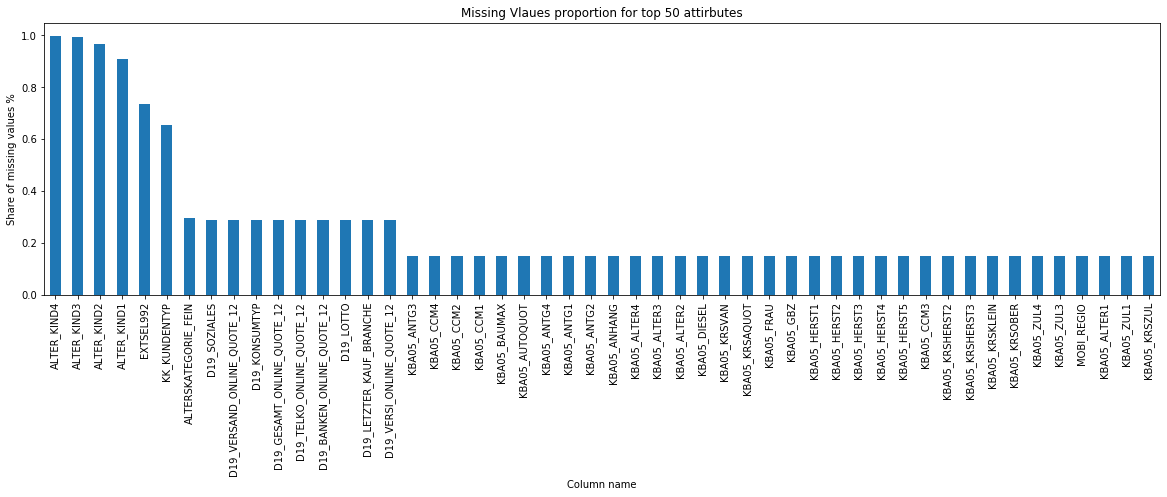

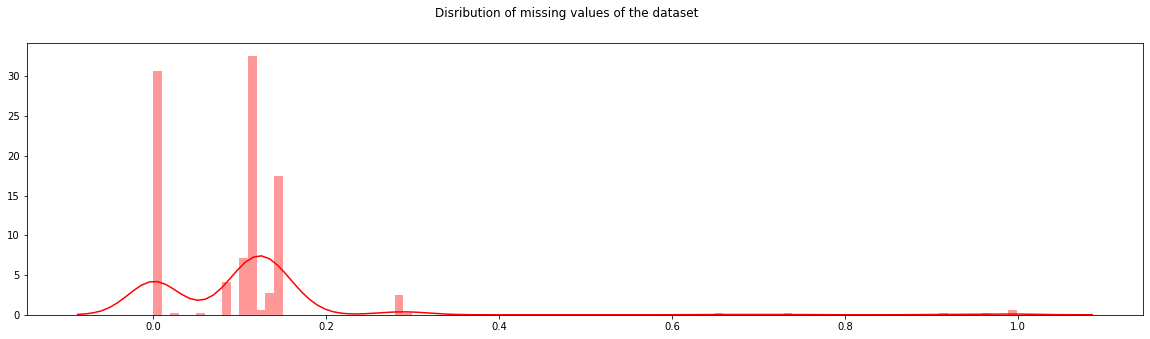

In [26]:
#lloking at the missings columns for AZIDAS
inspect_missings_column(azdias)

Looking at the given dataset with a number of bins of  10 
140484 of all rows have 10 missings or less, that are 16%. 
118087 of all rows have 20 missings or less, that are 13%. 
105805 of all rows have 30 missings or less, that are 12%. 
99264 of all rows have 40 missings or less, that are 11%. 
99231 of all rows have 50 missings or less, that are 11%. 
93168 of all rows have 60 missings or less, that are 10%. 
17 of all rows have 70 missings or less, that are 0%. 
0 of all rows have 80 missings or less, that are 0%. 
0 of all rows have 90 missings or less, that are 0%. 
0 of all rows have 100 missings or less, that are 0%. 


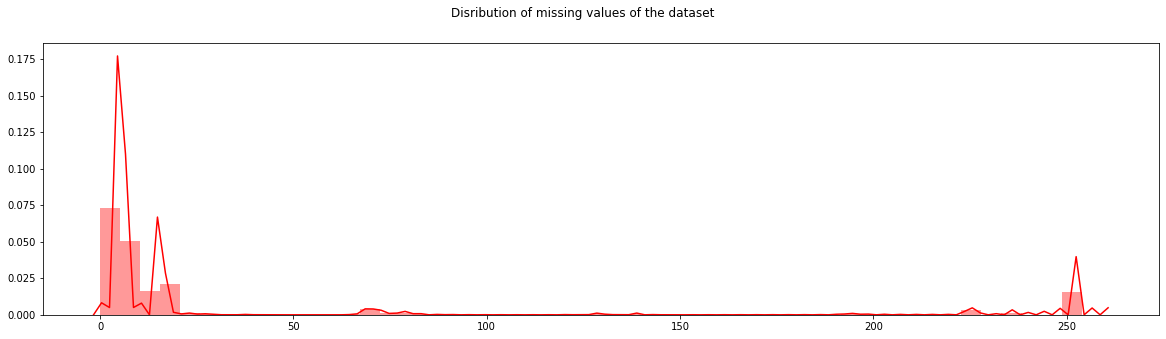

In [27]:
#lloking at the missings rows for AZIDAS
inspect_missings_row(azdias)

There are 369 columns that have 0% or more missings. That are 100.0% of all columns.
There are 253 columns that have 10% or more missings. That are 69.0% of all columns.
There are 253 columns that have 20% or more missings. That are 69.0% of all columns.
There are 6 columns that have 30% or more missings. That are 2.0% of all columns.
There are 6 columns that have 40% or more missings. That are 2.0% of all columns.
There are 5 columns that have 50% or more missings. That are 1.0% of all columns.
There are 4 columns that have 60% or more missings. That are 1.0% of all columns.
There are 4 columns that have 70% or more missings. That are 1.0% of all columns.
There are 4 columns that have 80% or more missings. That are 1.0% of all columns.
There are 4 columns that have 90% or more missings. That are 1.0% of all columns.


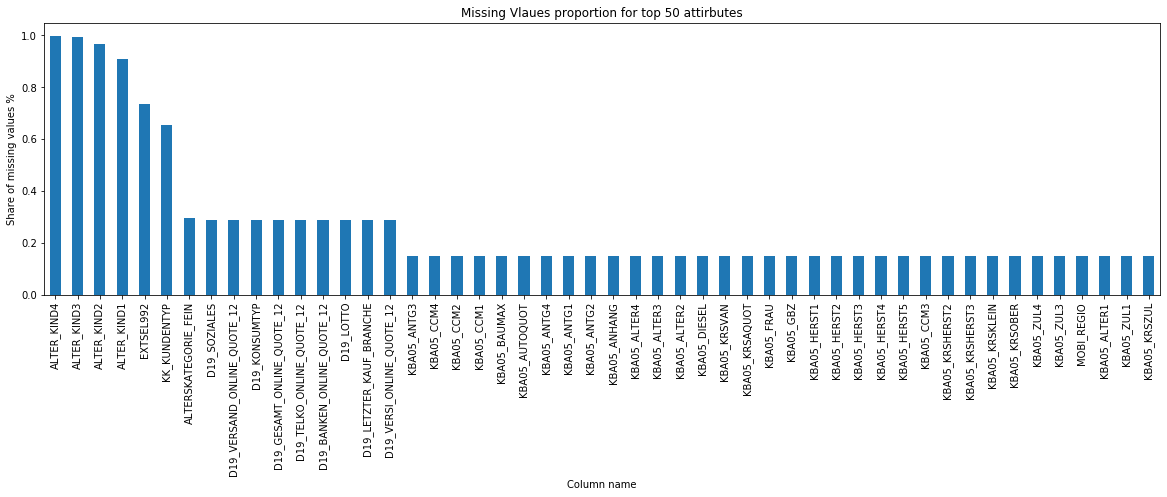

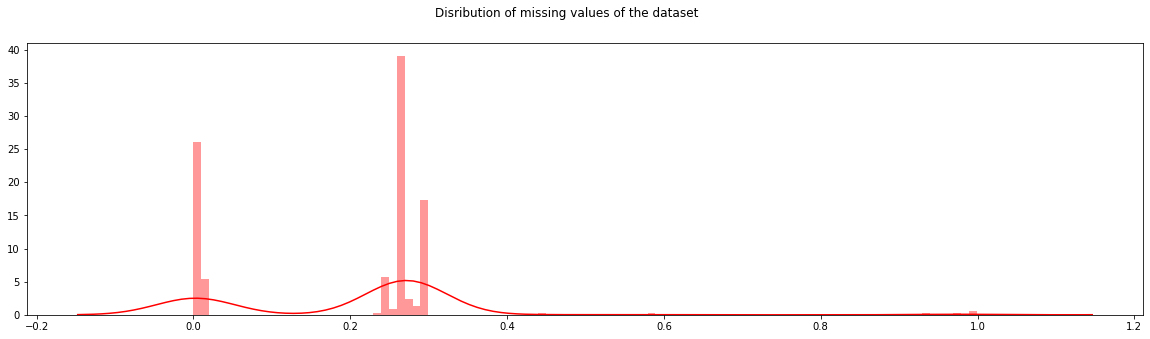

In [28]:
#lookng at the missing in the the columns for CUSTOMERS
inspect_missings_column(customers)

Looking at the given dataset with a number of bins of  10 
56574 of all rows have 10 missings or less, that are 30%. 
52572 of all rows have 20 missings or less, that are 27%. 
51281 of all rows have 30 missings or less, that are 27%. 
50763 of all rows have 40 missings or less, that are 26%. 
50751 of all rows have 50 missings or less, that are 26%. 
49911 of all rows have 60 missings or less, that are 26%. 
3 of all rows have 70 missings or less, that are 0%. 
0 of all rows have 80 missings or less, that are 0%. 
0 of all rows have 90 missings or less, that are 0%. 
0 of all rows have 100 missings or less, that are 0%. 


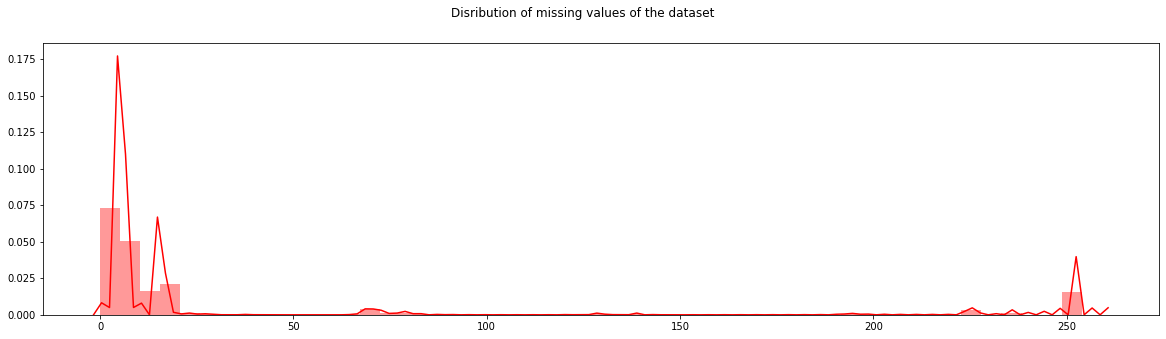

In [29]:
#lookng at the missing in the the rows for CUSTOMERS

inspect_missings_row(customers)

#### Unknown Data Relableling

In [30]:
# convert all unknown values from the azdias df to nans 
azdias_rep = change_unknown_to_nan(azdias) 
# convert all unknown values from the customers df to nans 
customers_rep = change_unknown_to_nan(customers) 

Looking at the data above there are oberservations that have more than  80% of missings these rows will be excluted from the dataset since they donot provide much enough inforamtion. 


#### Droping Columns and Rows based on their missings

In [31]:
def rem_nas(df, thresh_col = 0.3, thresh_row = 0.3):
    
    df_col =df.copy()
    
    print('---------Remove columns with more than {}% missings------------'.format(round(thresh_col*100)))
    print('The shape of the old dataframe:',df_col.shape)
    df_col = df_col.dropna(axis = 1 , thresh = df_col.shape[0]*(1 - thresh_col))
    print('The shape of the new dataframe:' ,df_col.shape)
    print('{} columns have been removed from the dataframe.'.format(df.shape[1]-df_col.shape[1]))

    print('=========================================')
    
    print('---------Remove rows with more than {}% missings------------'.format(round(thresh_row*100)))
    print('The shape of the old dataframe:',df_col.shape)
    
    df_clean = df_col.dropna(axis = 0 , thresh = df_col.shape[1]*(1-thresh_row))
    print('The shape of the new dataframe:' ,df_clean.shape)
    print('{} rows have been removed from the dataframe.'.format(df_col.shape[0]-df_clean.shape[0]))
   
    return df_clean


In [32]:
azdias_nan = rem_nas(azdias_rep)

---------Remove columns with more than 30% missings------------
The shape of the old dataframe: (891221, 366)
The shape of the new dataframe: (891221, 301)
65 columns have been removed from the dataframe.
---------Remove rows with more than 30% missings------------
The shape of the old dataframe: (891221, 301)
The shape of the new dataframe: (785326, 301)
105895 rows have been removed from the dataframe.


In [33]:
azdias_nan.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,910220,9.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,9.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,1.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,1.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,1.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1


#### Impute the rest of the missing values

The imputaion shpuld takte the variables type into account. 
The datasets mostly consitst of categorical but also ordinal and continus numerical features. 
For a lot of the features there exists an "neutral" element such as "none" or "no treansactions known" these are often either coded as a zero or ten. So the in the first part I will impute the nans of these features the this. 


In [34]:
az_imp = impute_missings(azdias_nan)

Col D19_BANKEN_DATUM no in the df anymore.
Col D19_BANKEN_OFFLINE_DATUM no in the df anymore.
Col D19_BANKEN_ONLINE_DATUM no in the df anymore.
Col D19_GESAMT_DATUM no in the df anymore.
Col D19_GESAMT_OFFLINE_DATUM no in the df anymore.
Col D19_GESAMT_ONLINE_DATUM no in the df anymore.
Col D19_TELKO_DATUM no in the df anymore.
Col D19_TELKO_OFFLINE_DATUM no in the df anymore.
Col D19_TELKO_ONLINE_DATUM no in the df anymore.
Col D19_VERSAND_DATUM no in the df anymore.
Col D19_VERSAND_OFFLINE_DATUM no in the df anymore.
Col D19_VERSAND_ONLINE_DATUM no in the df anymore.
Imputing 10er Values is done.
Imputing 9er Values is done.
Imputing Mean Values is done. 
Imputing most frequent values is done.
The rest of the columns are imputed with a zero. 


In [35]:
#checking if missings left 
az_imp.isna().mean().sum()

0.0

In [36]:
# checking whichb colums are of thype object
az_imp.select_dtypes(include='object')

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
1,8A,8,51,D19_UNBEKANNT,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W
5,8C,8,54,D19_ENERGIE,1992-02-12 00:00:00,W
...,...,...,...,...,...,...
891216,7A,7,41,D19_HAUS_DEKO,1992-02-10 00:00:00,W
891217,9D,9,51,D19_UNBEKANNT,1992-02-10 00:00:00,W
891218,4C,4,24,D19_BEKLEIDUNG_GEH,1992-02-10 00:00:00,W
891219,9D,9,51,D19_UNBEKANNT,1992-02-12 00:00:00,W


In [37]:
#checking the cardinality before applying one-hot encoding
for c in az_imp.select_dtypes(include='object').columns:
    print(c,": ",len(az_imp[c].value_counts()))

CAMEO_DEU_2015 :  44
CAMEO_DEUG_2015 :  9
CAMEO_INTL_2015 :  22
D19_LETZTER_KAUF_BRANCHE :  35
EINGEFUEGT_AM :  4464
OST_WEST_KZ :  2


#### Encoding of the differnt Varibales

Since the columns are not labeld correctly it is manually checked wich columsn are categoriucal an wich are ordinal or numerical.

In [39]:
az_enc = encode_data(az_imp)

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object')
Encode: CAMEO_DEU_2015
Encode: CAMEO_DEUG_2015
Encode: CAMEO_INTL_2015
Encode: D19_LETZTER_KAUF_BRANCHE
Column  EINGEFUEGT_AM  not found.
Encode: OST_WEST_KZ


In [40]:
az_enc.shape

(785326, 402)

In [41]:
#bild a data prepreateion pipeleine 

In [42]:
def data_load_and_prep(file_path, train_mode = True):
    '''
    This functions loads the csv files into python and provides all the transforamtion on the data that have been shown above.
    Finally it outputs a cleaned dataframe that can be used for machine learning algorithmes
    
    1.) The dataset is loaded into python 
    2.) Change the unknown values to nan values
    2.) Missings values are handeld by dropping some colums and rows 
    3.) Missing values are handeld by appropriate imputaiomn
    4.) Thte data is ecoded 
    
    '''
    
    # 1) Load the data into python
     
    dt = {'CAMEO_INTL_2015': object , 'CAMEO_DEUG_2015': object}
    df = pd.read_csv(file_path, sep=';', dtype=dtypes)
    
    #drop some columns that are not needed 
    if train_mode:
        dro = ['CUSTOMER_GROUP','ONLINE_PURCHASE','PRODUCT_GROUP']
        for c in dro:
            try:
                df.drop(c,axis=1, inplace = True)
                print('Drop ',c,' from customers dataset.')
            except:
                print('Column ',c,' was not in the df.')
                
    if train_mode: 
        df.drop(['LNR'],axis=1, inplace = True) 
        print('LNR Column is droped from the data.')
    else: print('LNR Column is kept in the data.')
        
    # 2) Change all the values taht are labeld as unkowns in the description file to nan values
    df = change_unknown_to_nan(df)
    
    # 3) Drop colmuns and rows wich exceed a the threshold of 30% of missings
    if train_mode:
        df = rem_nas(df)
    
    # 4) Impute the rest of the missings using appropirate strategies 
    df = impute_missings(df)
    
    # 5) Encode the objects to numericals 
    df_enc = encode_data(df)
    
    return df_enc 
    

In [43]:
# load an process the customers dataframe 
cu_enc = data_load_and_prep('data/Udacity_CUSTOMERS_052018.csv')

Drop  CUSTOMER_GROUP  from customers dataset.
Drop  ONLINE_PURCHASE  from customers dataset.
Drop  PRODUCT_GROUP  from customers dataset.
LNR Column is droped from the data.
---------Remove columns with more than 30% missings------------
The shape of the old dataframe: (191652, 365)
The shape of the new dataframe: (191652, 298)
67 columns have been removed from the dataframe.
---------Remove rows with more than 30% missings------------
The shape of the old dataframe: (191652, 298)
The shape of the new dataframe: (140354, 298)
51298 rows have been removed from the dataframe.
Col D19_BANKEN_DATUM no in the df anymore.
Col D19_BANKEN_OFFLINE_DATUM no in the df anymore.
Col D19_BANKEN_ONLINE_DATUM no in the df anymore.
Col D19_GESAMT_DATUM no in the df anymore.
Col D19_GESAMT_OFFLINE_DATUM no in the df anymore.
Col D19_GESAMT_ONLINE_DATUM no in the df anymore.
Col D19_TELKO_DATUM no in the df anymore.
Col D19_TELKO_OFFLINE_DATUM no in the df anymore.
Col D19_TELKO_ONLINE_DATUM no in the df

In [44]:
cu_enc.shape

(140354, 399)

In [45]:
az_enc = data_load_and_prep('data/Udacity_AZDIAS_052018.csv')

Column  CUSTOMER_GROUP  was not in the df.
Column  ONLINE_PURCHASE  was not in the df.
Column  PRODUCT_GROUP  was not in the df.
LNR Column is droped from the data.
---------Remove columns with more than 30% missings------------
The shape of the old dataframe: (891221, 365)
The shape of the new dataframe: (891221, 300)
65 columns have been removed from the dataframe.
---------Remove rows with more than 30% missings------------
The shape of the old dataframe: (891221, 300)
The shape of the new dataframe: (785326, 300)
105895 rows have been removed from the dataframe.
Col D19_BANKEN_DATUM no in the df anymore.
Col D19_BANKEN_OFFLINE_DATUM no in the df anymore.
Col D19_BANKEN_ONLINE_DATUM no in the df anymore.
Col D19_GESAMT_DATUM no in the df anymore.
Col D19_GESAMT_OFFLINE_DATUM no in the df anymore.
Col D19_GESAMT_ONLINE_DATUM no in the df anymore.
Col D19_TELKO_DATUM no in the df anymore.
Col D19_TELKO_OFFLINE_DATUM no in the df anymore.
Col D19_TELKO_ONLINE_DATUM no in the df anymore

In [46]:
az_enc.shape

(785326, 401)

### PCA as preperation 

Since there are still more than 400 columns in the datasets, PCA is conducted in order do lower the dimesnions of the datasets. 

In [47]:
#find common columns in azdias and customwers 
comon_cols = np.intersect1d(cu_enc.columns, az_enc.columns )
drop_azdias = np.setdiff1d(az_enc.columns, comon_cols)
drop_customers = np.setdiff1d(cu_enc.columns, comon_cols)

az_enc.drop(drop_azdias,axis=1,inplace = True)
cu_enc.drop(drop_customers,axis=1,inplace=True)

In [48]:
az_enc.shape

(785326, 399)

In [49]:
cu_enc.shape

(140354, 399)

In [627]:
def learn_principal_components(df, percent):
    '''
    This method lerns a PCA based for a given df and a percentage. 
    
    Input:
        df- a data frame the pca should be applyed to 
        float- a nuber between 0 and 1 indicating what percentage of the variance should be preserved
    Output
    
    '''
    
    # Bring data into standard form 
    scaled_df = StandardScaler().fit_transform(df)
    
    # pca 
    pca = PCA(n_components=df.shape[1], random_state=42) 
    pca.fit(scaled_df)     
    
    # percentage of variance explained by each pc  
    weight_pca = pca.explained_variance_ratio_
    perc_pca = np.cumsum(weight_pca)
    
    # Minimum number of principal components that perserves more than number of the given percentage of variance of df
    num_pca = np.where(perc_pca>=percent)[0][0]
    
    # PCA transform scaled df to pca
    pca = PCA(n_components=num_pca, random_state=42) 
    principal_components = pca.fit_transform(scaled_df) 
    df_principal= pd.DataFrame(principal_components)
    
    # Plot PCA results
    plt.figure(figsize=(10,5))
    plt.plot(perc_pca, color='b')
    plt.xlabel('Number Principal Components')
    plt.ylabel('Explained Variability')
    plt.xlim(0, df.shape[1])
    plt.show();
    print('The PCA with {}% variance results into keeping {} features.'.format(percent*100,num_pca))
               
    return df_principal, num_pca, pca


def apply_pca(df, n_components):
    
    scaled_df = StandardScaler().fit_transform(df)

    pca = PCA(n_components=n_components)
    pca.fit(scaled_df)
    df_pca = pd.DataFrame(pca.transform(scaled_df))
    
    return df_pca

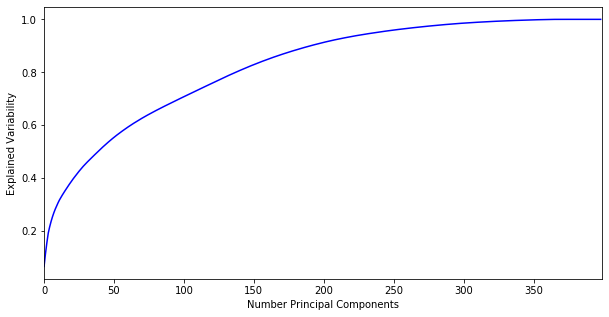

The PCA with 90.0% variance results into keeping 191 features.


In [393]:
azdias_pca, num_pca, pca = choose_principal_components(az_enc, percent=0.9)

By applying PCA to the data 191 features of the 399 are able to describe 90% of the variance. 

In [397]:
top_pc = pca.explained_variance_ratio_[:10]

In [412]:
i = 0
accumulated = 0
for v in top_pc:
    i = i+1
    print('The ',i, 'th compomnent explaines',round(v*100,) ,'% of the variance.')
    accumulated = accumulated +v 
    
print('The accumulated explained variance is ',round(accumulated*100,2),'%.')

The  1 th compomnent explaines 7.0 % of the variance.
The  2 th compomnent explaines 5.0 % of the variance.
The  3 th compomnent explaines 4.0 % of the variance.
The  4 th compomnent explaines 4.0 % of the variance.
The  5 th compomnent explaines 2.0 % of the variance.
The  6 th compomnent explaines 2.0 % of the variance.
The  7 th compomnent explaines 2.0 % of the variance.
The  8 th compomnent explaines 2.0 % of the variance.
The  9 th compomnent explaines 1.0 % of the variance.
The  10 th compomnent explaines 1.0 % of the variance.
The accumulated explained variance is  29.56 %.


Nearly 30% of the variance can be explained by the top 10 principal components. 

In [415]:
def get_pca_features(pca, num_comp = 3)
    for c in np.arange(0,num_comp):
        weight = pca.components_[0]
        df_features = pd.DataFrame(weights_array, index = column_names, columns=['weight'])
    return df_features.sort_values(by='weight', ascending=False).round(2)

#### Perfrom PCA on customers dataframe

In [413]:
customers_pc = apply_pca(cu_enc,191)

In [436]:
# Perform the prviously learnd PCA on the customers datapca on the customer dataset
cu_std = StandardScaler().fit_transform(cu_enc)
customers_pca = pca.transform(cu_std)

Now the PCA is completed on both dataframes. To explain 90% of variance 191 principal cpmponents are needed and thereby keept. 
In the following thy will be used to perfrom a clustering on the data. 

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [55]:
def kmean_clsuter_evaluation(df, cluster_min = 2, cluster_max = 20):
    '''
    INPUT 
    df - pandas dataframe to train k-means on 
    
    OUTPUT
    None
    
    This function display elbow plot for k-mean clustering on dataframe. 
    
    '''
    Sum_of_squared_distances = []
    
    for k in range(cluster_min, cluster_max + 1):
        # run k-means clustering
        k_means = KMeans(n_clusters=k, random_state=0).fit(df)
        # Record sum of squared distances of samples to the nearest cluster center
        Sum_of_squared_distances.append(k_means.inertia_)
        print('-----Computing Cluster No. {} ------'.format(k))
       

    #The elbow method as a first evaluation metic 
    plt.figure(figsize = (10,5))
    plt.plot(range(cluster_min, cluster_max + 1), Sum_of_squared_distances, marker='o', linestyle='--')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Sum of squared distances')
    plt.title('K-Means with PCA Clustering')
    plt.show()
    

-----Computing Cluster No. 2 ------
-----Computing Cluster No. 3 ------
-----Computing Cluster No. 4 ------
-----Computing Cluster No. 5 ------
-----Computing Cluster No. 6 ------
-----Computing Cluster No. 7 ------
-----Computing Cluster No. 8 ------
-----Computing Cluster No. 9 ------
-----Computing Cluster No. 10 ------
-----Computing Cluster No. 11 ------
-----Computing Cluster No. 12 ------
-----Computing Cluster No. 13 ------
-----Computing Cluster No. 14 ------
-----Computing Cluster No. 15 ------
-----Computing Cluster No. 16 ------
-----Computing Cluster No. 17 ------
-----Computing Cluster No. 18 ------
-----Computing Cluster No. 19 ------
-----Computing Cluster No. 20 ------


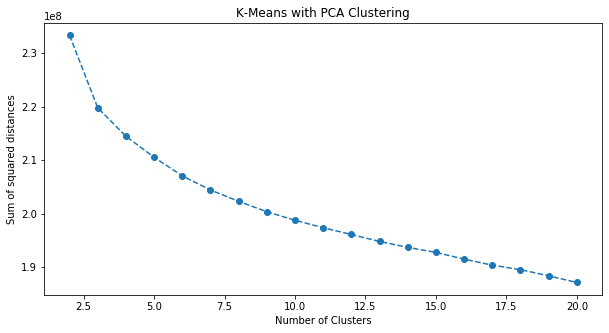

In [56]:
#compute k-means clsutering to find the optimal number of clusters
kmean_clsuter_evaluation(azdias_pca, cluster_max = 20)

Though the ellbow is not very clearly identifiable it shows that the clustering should be done with 12-15 Clsuters
In this case 13 Clsuters seem to be a reasonabale chloice. 

In [ ]:
# Set PCA and KMeans parameters
pca_components = 191
kmeans_clusters = 13

In [434]:
# Train & fit K-Means on the azdias dataset with the previously evaluated ideal number of clusters
kmeans = KMeans(n_clusters=13, random_state=42)
km_model = kmeans.fit(azdias_pca)

azdias_cluster = pd.DataFrame(km_model.predict(azdias_pca), columns=['cluster'])

In [437]:
#prepare a dataframe that provides descriptive inforamtion for each cluster 
customers_cluster = pd.DataFrame(km_model.predict(customers_pca), columns=['cluster'])
azdias_cl_cnt = azdias_cluster['cluster'].value_counts().sort_index()
customers_cl_cnt = customers_cluster['cluster'].value_counts().sort_index()

comb_clusters = pd.concat([azdias_cl_cnt, customers_cl_cnt], axis=1).reset_index()
comb_clusters.columns = ['cluster', 'population_count', 'customers_count']
comb_clusters['cluster'] = comb_clusters.index+1

comb_clusters['population_share'] = comb_clusters['population_count']/comb_clusters['population_count'].sum()*100
comb_clusters['customers_share'] = comb_clusters['customers_count']/comb_clusters['customers_count'].sum()*100
comb_clusters['diff_share'] = comb_clusters['customers_share'] - comb_clusters['population_share']

In [748]:
#short look at the data
comb_clusters

,cluster,population_count,customers_count,population_share,customers_share,diff_share
0,1,78729,17381,10.025009,12.383687,2.358678
1,2,79926,18175,10.177430,12.949399,2.771970
2,3,93029,21860,11.845909,15.574903,3.728995
3,4,50338,4522,6.409822,3.221853,-3.187969
4,5,65426,7573,8.331063,5.395642,-2.935420
5,6,15608,5886,1.987455,4.193682,2.206227
6,7,64318,8521,8.189975,6.071077,-2.118897
7,8,82564,20783,10.513341,14.807558,4.294217
8,9,95200,12315,12.122354,8.774242,-3.348112
9,10,42479,10574,5.409091,7.533807,2.124716


In [565]:
#Prepare data so it can be plotted clusterwise in a grouped barplot
population_ratio = comb_clusters[['cluster','population_share']]
population_ratio = population_ratio.rename(columns={'population_share':'value'})
population_ratio.set_index(pd.DataFrame(['Population']*population_ratio.shape[0])[0], inplace = True)

custumer_ratio = comb_clusters[['cluster','customers_share']]
custumer_ratio = custumer_ratio.rename(columns={'customers_share':'value'})
custumer_ratio.set_index(pd.DataFrame(['Customers']*population_ratio.shape[0])[0], inplace = True)

cluster_plt = population_ratio.append(custumer_ratio)

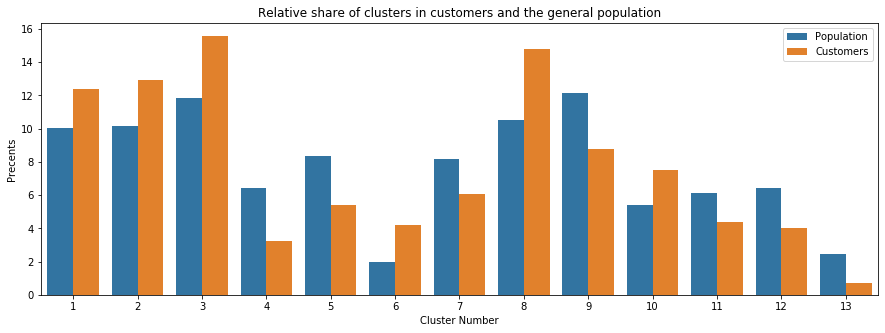

In [606]:
#plot a grouped bar chart of the clsters and their ratio 
plt.figure(figsize=(15, 5))
sns.barplot(x="cluster", y="value", hue= 0, data=cluster_plt)
plt.xlabel('Cluster Number')
plt.ylabel('Precents')
plt.title('Relative share of clusters in customers and the general population')
plt.legend()
plt.show()

The plot shows the distribution of the population and the customer data across the 13 selected clsuters. 
It can be seen that the in the cusotomers data the clusters are more uneven.
For the customer data seem to peek in clsuters 3 and 8. For differentiation to the general population let's look at the next figure. 

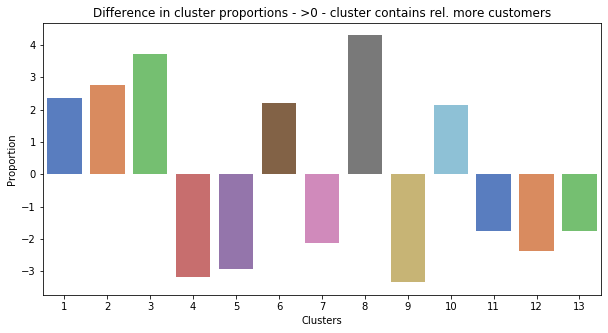

In [747]:
#plot the difference in proportion for the clusters
fig = plt.figure(figsize=(10,5))
ax = sns.barplot(x = comb_clusters['cluster'], y = comb_clusters['diff_share'], palette="muted")
ax.set(title=f'Difference in cluster proportions - >0 - cluster contains rel. more customers', ylabel='Proportion', xlabel='Clusters');

The figure aboves shows the deviation from the customers data from the genreal population. 
It shows that clsuter 8 and 3 are good chices to investigate in order to find out what attributes make a arvato customer. 

Conversly clsuter 9 and 4 apper to be negative exaples. 

#### Investigate the clsuters of intrest 

In [694]:
#select the clusters to select the centers from
customers_center = kmeans.cluster_centers_[8]
azdias_center = kmeans.cluster_centers_[9]

In [695]:
#invert transform the inforamtion for the two slected clusters
center_customers_inv = pca.inverse_transform(customers_center)
center_azidas_inv = pca.inverse_transform(azdias_center)

In [696]:
#retrieve the original cloumn names from the datasets
cu_feature_names = cu_enc.columns
az_feature_names = az_enc.columns

In [723]:
features = pd.DataFrame({"feature" : cu_feature_names, "intrested_cluster_8": center_customers_inv,"not_intrested_cluster_9": center_azidas_inv}) #, 'Difference': (center_customers_inv - center_general_inv)})

In [724]:
features

,feature,intrested_cluster_8,not_intrested_cluster_9
0,AKT_DAT_KL,0.488123,0.125531
1,ALTERSKATEGORIE_FEIN,0.220914,-0.130124
2,ANZ_HAUSHALTE_AKTIV,-0.146463,0.265837
3,ANZ_HH_TITEL,-0.083624,0.490099
4,ANZ_KINDER,0.013472,-0.092035
...,...,...,...
394,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,0.014429,-0.029082
395,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,-0.081353,-0.074148
396,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,-0.104245,-0.031470
397,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,-0.033959,0.023601


In [725]:
#prepare a list to investigate the features that are more likely to be seen in the two selected clsuters
features['Difference'] = features['intrested_cluster_8'] - features['not_intrested_cluster_9']
features.sort_values(by='intrested_cluster_8',ascending = False ,inplace=True)

In [745]:
#plot and investigate cluster of persons which rather tned to become customres from clsuter 8
features.head(50).sort_values(by='intrested_cluster_8').head(20)

,feature,intrested_cluster_8,not_intrested_cluster_9,Difference
158,KBA13_HALTER_50,0.231878,-0.880311,1.112189
283,VK_DHT4A,0.232466,0.209829,0.022636
276,UMFELD_ALT,0.234500,-0.098292,0.332792
200,KBA13_MERCEDES,0.235303,1.078907,-0.843605
349,CAMEO_INTL_2015_24,0.249700,-0.135466,0.385166
117,KBA13_ALTERHALTER_60,0.250048,-0.907407,1.157455
99,KBA05_SEG10,0.254374,0.506231,-0.251857
206,KBA13_SEG_GELAENDEWAGEN,0.261742,0.664314,-0.402572
65,KBA05_DIESEL,0.265274,0.231230,0.034044
393,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,0.270854,0.105151,0.165703


Looking at features where the difference for customers it can be seen that peeople who are customers are rather wealthy.
They are e.g. interested in investment. Living in the city center. And show a propensity to consume. 

In [746]:
#plot and investigate features that are more likely to be seen in cluster 9
features.tail(20).sort_values(by='not_intrested_cluster_9').head(10)

,feature,intrested_cluster_8,not_intrested_cluster_9,Difference
236,LP_LEBENSPHASE_FEIN,-0.448156,-0.279917,-0.168239
237,LP_LEBENSPHASE_GROB,-0.419268,-0.274338,-0.144930
239,LP_STATUS_GROB,-0.357825,-0.249040,-0.108786
35,FINANZ_MINIMALIST,-0.720095,-0.222307,-0.497789
14,CJT_TYP_3,-0.709386,-0.163474,-0.545912
260,SEMIO_ERL,-0.479842,-0.068190,-0.411652
16,CJT_TYP_5,-0.845198,-0.061545,-0.783652
15,CJT_TYP_4,-0.702081,-0.051678,-0.650404
17,CJT_TYP_6,-0.655980,-0.037875,-0.618105
39,FINANZTYP,-0.642294,-0.009790,-0.632504


Conversly, people with rather limited financial wealth are more unlikely to become customers. 

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [323]:
#Load and clean the dataset
mailout_train = data_load_and_prep('data/Udacity_MAILOUT_052018_TRAIN.csv')

Column  CUSTOMER_GROUP  was not in the df.
Column  ONLINE_PURCHASE  was not in the df.
Column  PRODUCT_GROUP  was not in the df.
LNR Column is droped from the data.
---------Remove columns with more than 30% missings------------
The shape of the old dataframe: (42962, 366)
The shape of the new dataframe: (42962, 302)
64 columns have been removed from the dataframe.
---------Remove rows with more than 30% missings------------
The shape of the old dataframe: (42962, 302)
The shape of the new dataframe: (34997, 302)
7965 rows have been removed from the dataframe.
Col D19_BANKEN_DATUM no in the df anymore.
Col D19_BANKEN_OFFLINE_DATUM no in the df anymore.
Col D19_BANKEN_ONLINE_DATUM no in the df anymore.
Col D19_GESAMT_OFFLINE_DATUM no in the df anymore.
Col D19_GESAMT_ONLINE_DATUM no in the df anymore.
Col D19_TELKO_DATUM no in the df anymore.
Col D19_TELKO_OFFLINE_DATUM no in the df anymore.
Col D19_TELKO_ONLINE_DATUM no in the df anymore.
Col D19_VERSAND_DATUM no in the df anymore.
Col

In [350]:
mailout_y = mailout_train['RESPONSE']
mailout_X = mailout_train.drop('RESPONSE',axis = 1)

In [359]:
mailout_X.shape[0]

34997

In [360]:
mailout_y.shape[0]

34997

Text(0.5, 1.0, 'Distribution of customer response')

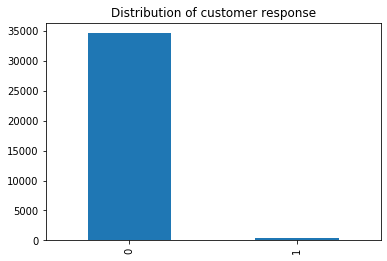

In [355]:
mailout_y.value_counts().plot.bar() 
plt.title('Distribution of customer response')


In [356]:
print('The training data shows a response rate of ',round(mailout_y.value_counts()[1] / mailout_train.shape[0] * 100, 2),'%. ')

The training data shows a response rate of  1.24 %. 


In [346]:
#Train and validation Set split since the test data is withhold

In [361]:
X_train, X_val, y_train, y_val = train_test_split(mailout_X, mailout_y, stratify = mailout_y, test_size=0.2 ,random_state=42)

In [266]:
#Since the target class is highly inbalanced an oversampeling startegy is choosen. 
#The GTB otherwise would predict just zeros in order to achieve a 99% accurcy

In [363]:
oversampler = SMOTE()
X_train_os, y_train_os = oversampler.fit_resample(X_train, y_train)

In [371]:
X_train_pc = apply_pca(X_train_os,137)
X_val_pc = apply_pca(X_train_os,137)

In [365]:
X_train_pc.loc[:,[50,60]]

,50,60
0,1.990791,-0.559821
1,-0.976606,0.390348
2,0.425351,1.408216
3,-0.066029,-0.056962
4,1.677415,0.215419
...,...,...
34992,-0.376305,2.252582
34993,0.259817,-0.254705
34994,0.856957,0.787993
34995,-0.630970,-0.221189


In [388]:
y_train_os.shape

(55298,)

In [389]:
X_train_os.shape

(55298, 402)

In [384]:
def XGB_Classify(X,y,max_depth =10):
# Define XGBClassifier
    xgbr = xgb.XGBClassifier(verbosity=0, max_depth=max_depth) 
    print(xgbr)
    # Fit model on downsampled training data
    xgbr.fit(X, y)
    # Predict on training data
    y_pred = xgbr.predict(X)
    # roc score
    roc = roc_auc_score(y_val, y_pred)
    print('ROC score: {}'.format(roc))
    # print("Training score: ", xgbr.score(X_train_pca, Y_train))
    # cross validation score
    results = cross_val_score(xgbr, X, y, cv=3)
    print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
    
    return xgbr, roc

In [625]:
X_train_pc.shape

(55298, 137)

In [626]:
y.shape

(42833,)

In [385]:
pca_model, pca_model_roc = XGB_Classify(X = X_train_pc, y = y)

XGBClassifier(max_depth=10, verbosity=0)


XGBoostError: [21:12:59] src/objective/multiclass_obj.cu:60: Check failed: preds.Size() == (static_cast<size_t>(param_.num_class) * info.labels_.Size()): SoftmaxMultiClassObj: label size and pred size does not match
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000001a23d8f469 dmlc::LogMessageFatal::~LogMessageFatal() + 57
  [bt] (1) 2   libxgboost.dylib                    0x0000001a23e25796 xgboost::obj::SoftmaxMultiClassObj::GetGradient(xgboost::HostDeviceVector<float> const&, xgboost::MetaInfo const&, int, xgboost::HostDeviceVector<xgboost::detail::GradientPairInternal<float> >*) + 470
  [bt] (2) 3   libxgboost.dylib                    0x0000001a23d8b0ee xgboost::LearnerImpl::UpdateOneIter(int, xgboost::DMatrix*) + 1278
  [bt] (3) 4   libxgboost.dylib                    0x0000001a23dabf9c XGBoosterUpdateOneIter + 172
  [bt] (4) 5   libffi.6.dylib                      0x00000001109aa884 ffi_call_unix64 + 76
  [bt] (5) 6   ???                                 0x00007ffedfdec5b0 0x0 + 140732654339504



### Making predictions with original columns 

In [ ]:
oversampler = SMOTE()
X_train_os, y_train_os = oversampler.fit_resample(X_train, y_train)

In [265]:
# Use GridSearchCV to optimize model
# Optmizing parameters  based ohttps://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html
parameters = {
     'xgbr__gamma': [0, 0.1],
     'xgbr__max_depth': [6, 10]
}

model = GridSearchCV(pipeline, param_grid=parameters, scoring='roc_auc', cv=4)
 
model.fit(X_train_os, y_train_os)

# Print the results for the Gridsearch of GBT
print("\nBest Parameters:", model.best_params_)


Best Parameters: {'xgbr__gamma': 0, 'xgbr__max_depth': 10}


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [278]:
X_test = data_load_and_prep('data/Udacity_MAILOUT_052018_TEST.csv')

Column  CUSTOMER_GROUP  was not in the df.
Column  ONLINE_PURCHASE  was not in the df.
Column  PRODUCT_GROUP  was not in the df.
LNR Column is droped from the data.
---------Remove columns with more than 30% missings------------
The shape of the old dataframe: (42833, 365)
The shape of the new dataframe: (42833, 301)
64 columns have been removed from the dataframe.
---------Remove rows with more than 30% missings------------
The shape of the old dataframe: (42833, 301)
The shape of the new dataframe: (34990, 301)
7843 rows have been removed from the dataframe.
Col D19_BANKEN_DATUM no in the df anymore.
Col D19_BANKEN_OFFLINE_DATUM no in the df anymore.
Col D19_BANKEN_ONLINE_DATUM no in the df anymore.
Col D19_GESAMT_OFFLINE_DATUM no in the df anymore.
Col D19_GESAMT_ONLINE_DATUM no in the df anymore.
Col D19_TELKO_DATUM no in the df anymore.
Col D19_TELKO_OFFLINE_DATUM no in the df anymore.
Col D19_TELKO_ONLINE_DATUM no in the df anymore.
Col D19_VERSAND_DATUM no in the df anymore.
Col

In [279]:
ID = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';', usecols=['LNR'])

In [280]:
y = pd.Series(y_test_est[:,1])

In [281]:
result = ID
result['RESPONSE'] = y

In [275]:
result

,LNR,RESPONSE
0,1754,0.106890
1,1770,0.087409
2,1465,0.012063
3,1470,0.023491
4,1478,0.009272
...,...,...
42828,67615,0.331797
42829,67938,0.023668
42830,67942,0.021014
42831,67949,0.109457


In [282]:
result.to_csv('predict_test.csv', index=False, sep=',', encoding='utf-8')